In [1]:
import collections
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy.stats as stats

from copia import chao1
from IPython.display import display, Markdown


In [4]:
# Setting style for figures
plt.style.use(['science', 'no-latex'])

mathprint = lambda x: display(Markdown(x))

figures_path = '../figures'


# Functions

In [5]:
def chao_wor(x, q, conf=0.95):
    '''
    Function to calculate Chao without replacement
    x =  input, list of counts
    q = sample fraction
    conf = confidence interval
    '''
    x = x[x > 0]
    n = x.sum() # sample size
    t = len(x)  # number of unique items
    # Convert the int64 to longs to ensure the numbers
    # don't get too big in the variance calculation
    f1 = (x == 1).sum().item() # number of singletons
    f2 = (x == 2).sum().item() # number of doubletons
    w = n / (n - 1)
    r = q / (1 - q)
    f0 = (f1 ** 2) / (2 * w * f2 + r * f1)

    # compute sd
    t1 = ((2 * w * f2 * (f0**2) + (f1**2) * f0) ** 2) / (f1 ** 5)
    t2 = (4 * (w**2) * f2) * ((f0 / f1)**4)
    var = f0 + t1 + t2
        
    z = abs(stats.norm.ppf((1 - conf) / 2))
    K = np.exp(z * np.sqrt(np.log(1 + var / f0 ** 2)))
    lci, uci = t + f0 / K, t + f0 * K
    return {
        "q": q,
        "f1": f1,
        "f2": f2,
        "f0": f0,
        "V_obs": t,
        "V_est": math.ceil(t + f0), 
        "var": var,
        "sd": np.sqrt(var),
        "lci": lci,
        "uci": uci,
        "Chao1": chao1(x)
    }


# def make_estimates(df, N_est, method, verbose=True):
#     if method == 'mean':
#         n_sailors_per_ship = df.groupby(['outward_voyage_id'])['vocop_id'].count().mean()
#     elif method == 'median':
#         n_sailors_per_ship = df.groupby(['outward_voyage_id'])['vocop_id'].count().median()
#     else:
#         print('wrong method, use "mean" or "median"')
    

#     N_est = int(n_sailors_per_ship * n_voyages)
#     q = N_obs / N_est
#     estimates = chao_wor(counts, q)
#     missing = 1 - estimates['V_obs'] / estimates['V_est']

#     if verbose:
#         mathprint(f'{str.capitalize(method)} number of sailors on a ship: {n_sailors_per_ship:.2f}')
#         mathprint(fr"The estimated number of sailors ($\hat{{N}}$) = {N_est:,}")
#         mathprint(fr"The observed fraction ($q$) = {q:.3f}")
#         mathprint(f"Chao1 estimates: {estimates}")
#         mathprint(f"Percentage of missing observations: {missing:.2%}")
#     else:
#         pass

#     return {
#         "N_est": N_est,
#         "missing_obs": missing,
#         "chao1_estimates": estimates
#     }


# Loading Data

In [19]:
# this csv includes all the outward voyages with their voyage id and year of departure
# this dataset is extracted from the Dutch-Asiatic Shipping dataset
# http://resources.huygens.knaw.nl/das/search


seafarer_counts = pd.read_csv('../data/total_counts.csv')
print('total number of voyages')
print(seafarer_counts['ships'].sum())

N_est = seafarer_counts['total_voyagers'].sum().astype(int)
print(f'Total number of seafarers: {N_est}')
seafarer_counts

total number of voyages
4352
Total number of seafarers: 947517


,period,ships,ships_onboard,voyagers_onboard,average_voyagers,total_voyagers
0,1633 - 1658,449,100,19617,196.2,88080
1,1658 - 1683,565,541,102112,188.7,106642
2,1683 - 1708,596,590,110203,186.8,111324
3,1708 - 1733,856,854,168004,196.7,168397
4,1733 - 1758,821,811,198291,244.5,200736
5,1758 - 1783,682,676,191610,283.4,193311
6,1783 - 1795,383,367,75726,206.3,79027


In [20]:
df = pd.read_csv('../data/voyages_clean.csv')
print('Loaded VOCAR contract data')
print(f'Total number of contracts: {df.shape[0]:,}')

# Only select disambiguated records
records = df.loc[df['disambiguated_person'] == 1, 'person_cluster_id'].astype(int).values
print(f'Number of disambiguated records: {len(records):,}')

df.head()

Loaded VOCAR contract data
Total number of contracts: 773,943
Number of disambiguated records: 546,973


,vocop_id,disambiguated_person,person_cluster_id,date_begin_contract,outward_voyage_id,year
0,1648348,0.0,NaN,1633-03-23,91474,1633
1,1574985,1.0,271923.0,1633-03-23,91474,1633
2,1574984,1.0,312073.0,1633-03-23,91474,1633
3,1574983,1.0,102537.0,1633-03-23,91474,1633
4,1574982,0.0,NaN,1633-03-23,91474,1633


### Variables

- __vocop_id__: the unique id for each contract <br>
- __disambiguated_person__: indicates whether the person is disambiguated (0 = no, 1 = yes). <br>
- __person_cluster_id__: id that refers to unique person. If a person is disambiguated, multiple contracts can belong to one person <br>
- __date_begin_contract__: start date of contract <br>
- __outward_voyage_id__: unique id of outward voyage. 

### Preparing Data

In [21]:
# construct dataframes for disambiguated and unique persons 
df_disambiguated = df.loc[df['disambiguated_person'] == 1]
df_unique_persons = df.loc[df['disambiguated_person'] == 1].drop_duplicates(subset=['person_cluster_id'])

### Plot Time Series

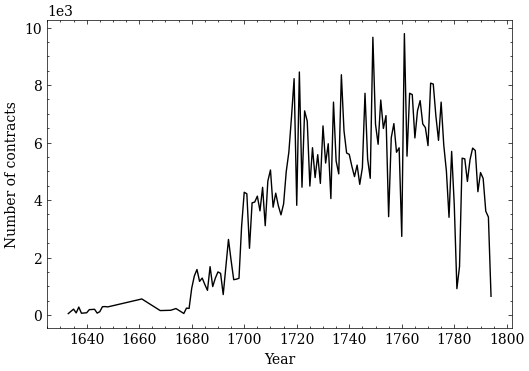

In [22]:
fig, ax = plt.subplots(figsize=(6, 4))

df_disambiguated.groupby('year')['date_begin_contract'].count().plot(ax=ax, color="k", label=None)
ax.set(xlabel='Year', ylabel='Number of contracts')
ax.ticklabel_format(axis="y", style="sci", scilimits=(3, 3))
plt.savefig(os.path.join(figures_path, 'total_contracts.png'), dpi=300)

In [23]:
# remove contracts with outward voyages id 0. 
# This is a placeholder to indicate voyages where the ship was unknown

# TODO: stay with same DF rather than making sailors_df

sailors_df = df[df['outward_voyage_id'] != 0]

### Analysis

In [24]:
_, counts = np.unique(records, return_counts=True)
N_obs, V_obs = counts.sum(), counts.shape[0]

mathprint(fr"The archive consists of $N$={N_obs:,} records and $V$={V_obs:,} unique sailors.")



The archive consists of $N$=546,973 records and $V$=460,274 unique sailors.

In [25]:
q = N_obs / N_est
estimates = chao_wor(counts, q)
missing = 1 - estimates['V_obs'] / estimates['V_est']


mathprint(fr"The estimated number of sailors ($\hat{{N}}$) = {N_est:,}")
mathprint(fr"The observed fraction ($q$) = {q:.3f}")
mathprint(f"Chao1 estimates: {estimates}")
mathprint(f"Percentage of missing observations: {missing:.2%}")

The estimated number of sailors ($\hat{N}$) = 947,517

The observed fraction ($q$) = 0.577

Chao1 estimates: {'q': 0.577269853733495, 'f1': 401179, 'f2': 42889, 'f0': 254008.74748237987, 'V_obs': 460274, 'V_est': 714283, 'var': 488899.1310150412, 'sd': 699.2132228548322, 'lci': 712916.0075827627, 'uci': 715656.8811561799, 'Chao1': 2336562.7429766366}

Percentage of missing observations: 35.56%

Note that `Chao1` gives an unrealistic lower bound of more than 2.3 million, which by far exceeds the know upper limit of $\hat{N}$. 

## Varying $q$-values

To get a better idea of the how strong the estimates depend on knowledge about $\hat{N}$, we plot $\hat{V}$ for different values $q$. 

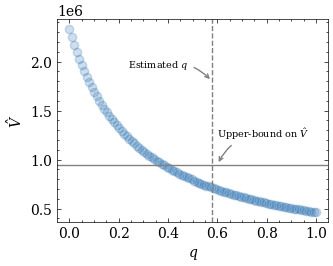

In [26]:
fig, ax = plt.subplots()
ratios = np.linspace(0, 1 - 1e-7, 100)
estimations = np.zeros(100)
for i, ratio in enumerate(ratios):
    estimations[i] = chao_wor(counts, ratio)["V_est"]
ax.plot(ratios, estimations, 'o', alpha=0.2)
ax.axvline(q, color="grey", ls="--")
ax.axhline(N_est, color="grey", ls="-")
ax.set(xlabel="$q$", ylabel=r"$\hat{V}$")

ax.annotate(
    "Estimated $q$",
    (q, 1.8*10**6),
    size="x-small",
    xytext=(-60, +10),
    textcoords="offset points",
    arrowprops=dict(
        arrowstyle="->", color="grey", connectionstyle="arc3,rad=-0.3"
    ),
)

ax.annotate(
    r"Upper-bound on $\hat{V}$",
    (0.6, N_est),
    size="x-small",
    xytext=(0, +20),
    textcoords="offset points",
    arrowprops=dict(
        arrowstyle="->", color="grey", connectionstyle="arc3,rad=0.3"
    ),
);

## Run analysis for every twenty-five year period

In [32]:
bins = list(range(1633, 1795, 25)) + [1795]
date_ranges = [(bins[i-1], bins[i]) for i in range(1, len(bins))]
mathprint(f'These are the date ranges: {date_ranges}')

These are the date ranges: [(1633, 1658), (1658, 1683), (1683, 1708), (1708, 1733), (1733, 1758), (1758, 1783), (1783, 1795)]

In [34]:
estimates = list()
V_observations = []
for index, (start, end) in enumerate(date_ranges):
    df_slice = sailors_df[sailors_df['year'].between(start, end, inclusive="left")]
    records = df_slice.loc[df_slice['disambiguated_person'] == 1, 'person_cluster_id'].astype(int).values
    _, counts = np.unique(records, return_counts=True)
    N, V_obs = counts.sum(), counts.shape[0]
    V_observations.append(V_obs)

    N_est = seafarer_counts.iloc[index]['total_voyagers']
    n_voyages = seafarer_counts.iloc[index]['ships']

    q = len(records) / N_est
    estimate = chao_wor(counts, q)
    estimate["N_est"] = N_est
    estimate['voyages'] = n_voyages
    estimate["period"] = f"{start} - {end}"
    estimate["records"] = len(records)
    estimates.append(estimate)

### Plot estimates over time

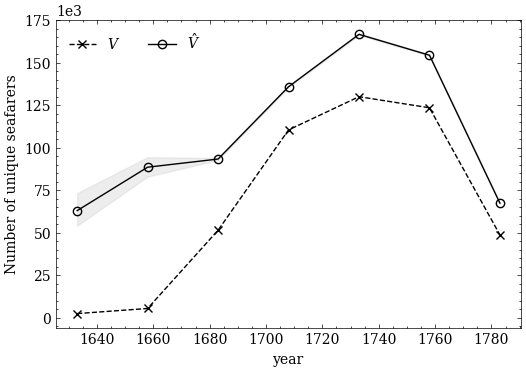

In [36]:


labels = [x[0] for x in date_ranges]

fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(labels, V_observations, '--x', label=r'$V$', color="k")
lci, uci, est = zip(*[(est["lci"], est["uci"], est["V_est"]) for est in estimates])
ax.plot(labels, est, '-o', color="k", label=r'$\hat{V}$', fillstyle="none")
ax.fill_between(labels, lci, uci, color="lightgrey", alpha=0.4)
ax.set(xlabel='year', ylabel='Number of unique seafarers')
ax.ticklabel_format(axis="y", style="sci", scilimits=(3, 3))
ax.legend(ncol=2)
plt.savefig('../figures/25year_plot.png', dpi=300)



## LaTeX tables

In [37]:
interesting_columns = ['period', 'voyages', 'q', 'N_est', 'V_obs', 'V_est', 'lci', 'uci', 'loss rate', 'Chao1']
formatters = {
    "q": lambda x: f"{x:.2f}",
    "loss rate": lambda x: f"{x:.2%}",
}
for column in ('voyages', 'N_est', 'V_obs', 'V_est', 'lci', 'uci', 'Chao1'):
    formatters[column] = lambda x: f"{x:,.0f}"

def format_column(x):
    return x if isinstance(x, str) else f"{x:,.0f}"

estimates_df = pd.DataFrame(estimates)
estimates_df["loss rate"] = 1 - estimates_df["V_obs"] / estimates_df["V_est"]
print(estimates_df[interesting_columns].to_latex(formatters=formatters))

\begin{tabular}{llrrrrrrrrr}
\toprule
{} &       period & voyages &    q &   N\_est &   V\_obs &   V\_est &     lci &     uci & loss rate &   Chao1 \\
\midrule
0 &  1633 - 1658 &     449 & 0.03 &  88,080 &   2,457 &  63,033 &  54,214 &  73,354 &    96.10\% & 215,522 \\
1 &  1658 - 1683 &     565 & 0.05 & 106,642 &   5,462 &  88,593 &  83,101 &  94,472 &    93.83\% & 497,150 \\
2 &  1683 - 1708 &     596 & 0.50 & 111,324 &  51,501 &  93,391 &  92,790 &  93,999 &    44.85\% & 409,425 \\
3 &  1708 - 1733 &     856 & 0.78 & 168,397 & 110,517 & 135,931 & 135,576 & 136,290 &    18.70\% & 540,560 \\
4 &  1733 - 1758 &     821 & 0.75 & 200,736 & 130,069 & 166,763 & 166,326 & 167,205 &    22.00\% & 725,923 \\
5 &  1758 - 1783 &     682 & 0.76 & 193,311 & 123,553 & 154,479 & 154,082 & 154,880 &    20.02\% & 574,654 \\
6 &  1783 - 1795 &     383 & 0.69 &  79,027 &  48,738 &  67,451 &  67,123 &  67,784 &    27.74\% & 293,352 \\
\bottomrule
\end{tabular}



/var/folders/jj/fdhkrkb14cn5hxzb8wkp1vjc0000gn/T/ipykernel_46556/2389406760.py:14: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(estimates_df[interesting_columns].to_latex(formatters=formatters))
